In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

d2l.use_svg_display()

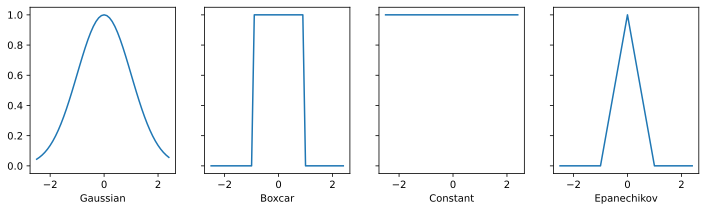

In [ ]:
# Define some kernels

## (For simplicity we define k=0 at the origin)
def gaussian(x):
    return torch.exp(-x**2 / 2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))

kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')
x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)

d2l.plt.show()


In [ ]:
# Attention Pooling via Nadaraya-Watson Regression

## defining some training data
def f(x):
    return 2 * torch.sin(x) + x

n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

In [4]:
x_train

tensor([0.2572, 0.2872, 0.3547, 0.3657, 0.6503, 0.7387, 1.0246, 1.2500, 1.2687,
        1.2818, 1.5573, 1.6158, 1.7753, 1.9416, 2.1361, 2.2042, 2.3581, 2.3588,
        2.4475, 2.4887, 2.4892, 2.6166, 2.8022, 2.8499, 3.0730, 3.0819, 3.1864,
        3.1940, 3.2590, 3.3184, 3.3984, 3.7316, 3.7358, 3.7869, 3.9690, 4.2131,
        4.3217, 4.4131, 4.5321, 4.6393])

In [5]:
y_train

tensor([ 1.3152,  0.0237,  2.1277, -0.4278,  1.1495,  2.1797,  3.7766,  5.3862,
         5.0995,  3.0057,  4.1312,  2.1475,  3.7284,  2.2720,  3.5757,  4.5054,
         3.0445,  4.3237,  5.1769,  4.1729,  3.6880,  2.4509,  3.2189,  3.2560,
         4.3879,  4.0004,  3.8323,  3.4830,  0.8018,  2.4515,  3.0933,  4.3280,
         1.4564,  3.8035,  3.0507,  2.4899,  4.9729,  4.4356,  3.9743,  3.6052])

In [6]:
x_val

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000,
        1.8000, 1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000,
        2.7000, 2.8000, 2.9000, 3.0000, 3.1000, 3.2000, 3.3000, 3.4000, 3.5000,
        3.6000, 3.7000, 3.8000, 3.9000, 4.0000, 4.1000, 4.2000, 4.3000, 4.4000,
        4.5000, 4.6000, 4.7000, 4.8000, 4.9000])

In [7]:
y_val

tensor([0.0000, 0.2997, 0.5973, 0.8910, 1.1788, 1.4589, 1.7293, 1.9884, 2.2347,
        2.4667, 2.6829, 2.8824, 3.0641, 3.2271, 3.3709, 3.4950, 3.5991, 3.6833,
        3.7477, 3.7926, 3.8186, 3.8264, 3.8170, 3.7914, 3.7509, 3.6969, 3.6310,
        3.5548, 3.4700, 3.3785, 3.2822, 3.1832, 3.0833, 2.9845, 2.8889, 2.7984,
        2.7150, 2.6403, 2.5763, 2.5245, 2.4864, 2.4634, 2.4568, 2.4677, 2.4968,
        2.5449, 2.6126, 2.7002, 2.8077, 2.9351])

In [ ]:
# Let each validation feature be a query, and each training feature–label pair be a key–value pair. 
# As a result, the normalized relative kernel weights (attention_w below) are the attention weights.

# attention-pooling
def nadaraya_watson(x_train, y_train, x_val, kernel):
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    # Each column/row corresponds to each query/key
    k = kernel(dists).type(torch.float32)
    # Normalization over keys for each query
    attention_w = k / k.sum(0)
    y_hat = y_train@attention_w
    return y_hat, attention_w

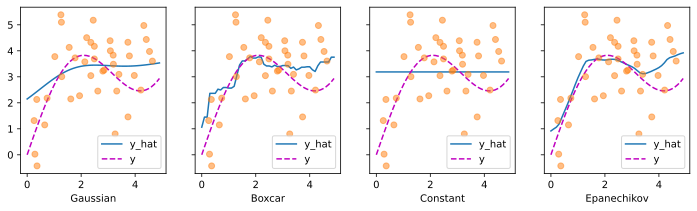

In [ ]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel) # evaluation over q (x_val)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5);
        ax.set_xlabel(name)
        if not attention:
            ax.legend(['y_hat', 'y'])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

plot(x_train, y_train, x_val, y_val, kernels, names)


In [17]:
n2 = 200
x_train2, _ = torch.sort(torch.rand(n2) * 5)
y_train2 = f(x_train2) + torch.randn(n2)
x_val2 = torch.arange(0, 5, 0.1)
y_val2 = f(x_val2)

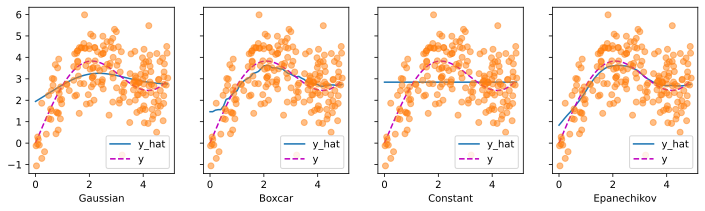

In [18]:
plot(x_train2, y_train2, x_val2, y_val2, kernels, names)

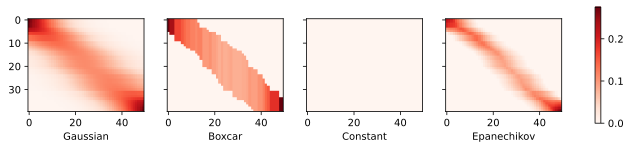

In [ ]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True) # similarity between queries and keys

In [21]:
# Adapting Attention Pooling

sigmas = (0.1, 0.2, 0.5, 1)
names = ['Sigma ' + str(sigma) for sigma in sigmas]

def gaussian_with_width(sigma):
    # sigma^2: determines the width of the kernel
    return (lambda x: torch.exp(-x**2 / (2*sigma**2)))

kernels = [gaussian_with_width(sigma) for sigma in sigmas]
kernels

[<function __main__.gaussian_with_width.<locals>.<lambda>(x)>,
 <function __main__.gaussian_with_width.<locals>.<lambda>(x)>,
 <function __main__.gaussian_with_width.<locals>.<lambda>(x)>,
 <function __main__.gaussian_with_width.<locals>.<lambda>(x)>]

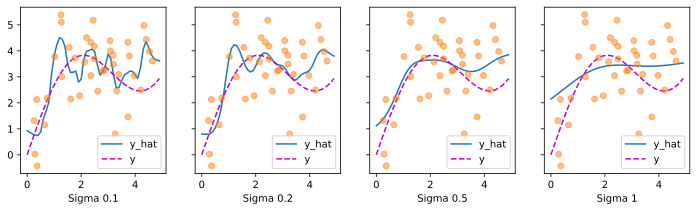

In [ ]:
plot(x_train, y_train, x_val, y_val, kernels, names) # the narrower the kernel, the less smooth the estimate

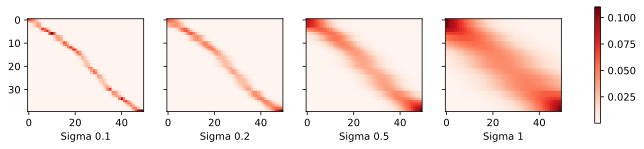

In [ ]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

# It is also clear that picking the same width might not be ideal. 
# In fact, Silverman (1986) proposed a heuristic that depends on the local density. 
# Many more such “tricks” have been proposed. For instance, Norelli et al. (2022) used a 
# similar nearest-neighbor interpolation technique for designing cross-modal image and text representations.